In [15]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.models.utils import cnc_add_y_label_binary
from datetime import datetime

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
path_data_dir = Path().cwd().parent.parent / "data"
print(path_data_dir)

/home/tim/Documents/feat-store/data


In [16]:
# get the feature dataframe
df = pd.read_csv(path_data_dir / "processed" / "cnc" / "cnc_features_custom_1" / "cnc_features_54_custom_1.csv")
df["unix_date"] = df["id"].apply(lambda x: int(x.split("_")[0]))
df["tool_no"] = df["id"].apply(lambda x: int(x.split("_")[-2]))
df["index_no"] = df["id"].apply(lambda x: int(x.split("_")[-1]))

df_labels = pd.read_csv(path_data_dir / "processed" / "cnc" / "high_level_labels_MASTER_update2020-08-06_new-jan-may-data_with_case.csv")

df = cnc_add_y_label_binary(df, df_labels, col_list_case=['case_tool_54'])
df = df.dropna(axis=0)

# only select one index_no
# df = df[df["index_no"] == 5]

In [17]:
df.head()

,id,current__spkt_welch_density__coeff_2,current__spkt_welch_density__coeff_5,current__spkt_welch_density__coeff_8,"current__fft_coefficient__attr_""real""__coeff_0","current__fft_coefficient__attr_""real""__coeff_1","current__fft_coefficient__attr_""real""__coeff_2","current__fft_coefficient__attr_""real""__coeff_3","current__fft_coefficient__attr_""real""__coeff_4","current__fft_coefficient__attr_""real""__coeff_5",...,"current__matrix_profile__feature_""max""__threshold_0.98","current__matrix_profile__feature_""mean""__threshold_0.98","current__matrix_profile__feature_""median""__threshold_0.98","current__matrix_profile__feature_""25""__threshold_0.98","current__matrix_profile__feature_""75""__threshold_0.98",unix_date,tool_no,index_no,case_tool_54,y
0,1540299830_54_5,1.304963e+06,6676.951102,1691.911788,2192305.0,-423581.455083,-219584.908770,6796.192624,20766.002788,-34544.604220,...,4.074220,2.233805,2.346632,1.796332,2.620527,1540299830,54,5,1,0
18,1540300726_54_5,1.322588e+06,6354.084876,1393.756419,2189719.0,-424512.587093,-222907.895163,4264.959064,18917.087017,-35007.960275,...,4.012193,2.611657,2.780102,2.134665,3.072805,1540300726,54,5,1,0
23,1540301084_54_5,1.320503e+06,5625.829408,1798.857413,2190652.0,-424084.770196,-222663.378645,3404.456873,17468.492096,-35575.688251,...,3.602263,2.229491,2.284337,1.763112,2.617456,1540301084,54,5,1,0
34,1540301801_54_5,1.313190e+06,6657.507633,1523.459302,2196547.0,-424078.116257,-221178.915318,5956.911637,21328.449930,-33259.075621,...,4.692448,2.684562,2.706917,2.294286,3.056472,1540301801,54,5,1,0
43,1540302696_54_5,1.307216e+06,5946.037995,1423.796646,2213133.0,-429338.888245,-226324.516864,3463.286607,20279.267008,-34639.471848,...,3.903152,2.244080,2.214881,1.893850,2.509688,1540302696,54,5,1,0


In [21]:
cmap = sns.cubehelix_palette(6, rot=-.25, light=.7, as_cmap=True)
sns.set(font_scale=1.1,style='whitegrid')

In [29]:
def plot_features_by_average_index_mpl(df, feat_to_trend, tool_no=54, index_list=[1,2],
                                       chart_height=9000,start_index=1500, stop_index=4700):
    '''Function to plot the feature table results'''
    
    def convert_to_datetime(cols):
        unix_date = cols[0]
        value = datetime.fromtimestamp(unix_date)
        return value
    
    df = df[(df['tool_no']==tool_no) & (df['index_no'].isin(index_list))].groupby(['unix_date'], as_index=False).mean()
    df = df.reset_index(drop=True).sort_values('unix_date')
    df['date'] = df[['unix_date']].apply(convert_to_datetime, axis=1)
    df['date_ymd'] = pd.to_datetime(df['date'],unit='s').dt.to_period('D')
    # df['failed'].fillna(0, inplace=True, downcast='int')
    
    # drop labels with 2
    # df = df[df['failed'].isin([0,1])]
    df = df[start_index:stop_index]
    df = df.reset_index(drop=True)
#     df.to_csv('groupby_csv_test.csv')
    
    # get date-changes
    # https://stackoverflow.com/questions/19125661/find-index-where-elements-change-value-numpy
    v=np.array(df['date_ymd'], dtype=datetime)
    date_change_list = np.where(v[:-1] != v[1:])[0]
    
    feat_list = []
    feat_title_list = []
    for feat in feat_to_trend:
        feat_list.append([feat, feat_to_trend[feat]])
        feat_title_list.append(feat_to_trend[feat])

    index_str = ''
    index_str_file = ''
    for i in index_list:
        index_str += str(i)+', '
        index_str_file += str(i)+'_'

    title_chart = 'Features for Tool {}, Averaged Across Splits (splits on metal-cutting)'.format(tool_no)

#     title_chart = 'Features for Tool {}, Averaged Across Cut Splits {}'.format(tool_no, index_str[:-2])

    file_name = 'tool_{}_avg_splits_{}.pdf'.format(tool_no,index_str_file[:-1])

    cols = 1
    rows = int(len(feat_to_trend) / cols) 
    if (len(feat_to_trend) % cols) != 0:
        rows += 1

    # Initialize figure with subplots
    
    fig, ax = plt.subplots(rows, cols, figsize=(5,3.5),dpi=600)
    pal = sns.cubehelix_palette(6, rot=-.25, light=.7)
    
#     fig = make_subplots(rows=rows, cols=cols,subplot_titles=feat_title_list)  

    # get lenght of features
    l = len(feat_to_trend)
    len_data = len(df)

    # iterate through each feature number and plot on chart
    counter = 0
    for i in range(rows):
        for j in range(cols):
            if counter < l:
                trend_value = feat_list[counter][0]
                title_plot = feat_title_list[counter]
                
                min_plot_val = np.min(df[trend_value])
                max_plot_val = np.max(df[trend_value])
                len_trend_data = len(df[trend_value])

                if title_plot != feat_title_list[counter]:

                    print('ERROR IN SUB-PLOT TITLE')

                for failed_label in range(0,2):
                    df1 = df[df['y'] == failed_label].copy()
                    
                    # define the colors for the markers
                    # can find default colors for theme via:
                    # >> plotly_template = pio.templates["plotly_white"]
                    # >> plotly_template.layout
                    
                    color_label = [pal[3],'#e31a1c','#b2df8a']
                    color_outline = [pal[5], '#b51516','#b51516']

                    x = df1.index.values
#                     print('### Min x:', np.min(x))
                    y = df1[trend_value]
#                     print(np.shape(y))
#                     print(np.min(y))
                    p = df1[['unix_date','date']].values
                    point_name=[]
                    for d in p:
                        if failed_label == 1:
                            point_name.append('Label: Wear, '+ str(d[1])+", "+str(d[0]))
                        elif failed_label == 2:
                            point_name.append('Label: Ignore, '+ str(d[1])+", "+str(d[0]))
                        else:
                            point_name.append(str(d[1])+", "+str(d[0]))
            
                    # Add traces
                    # how to add hover text, https://plot.ly/python/hover-text-and-formatting/
                    # Scattergl documentation: 
                        # https://plot.ly/python-api-reference/generated/plotly.graph_objects.Scattergl.html
                        
                    ax[i].scatter(x, y, s=4, color=color_label[failed_label], 
                                  alpha=0.4, 
                                  linewidths=0, edgecolors=color_outline[failed_label], 
                                  label=failed_label)
                    
#                     fig.add_trace(go.Scattergl(x=x, y=y, mode='markers',
#                                                showlegend=False,
#                                                hovertext=point_name, 
#                                                hoverinfo='text', marker=dict(color = color_label[failed_label])), 
#                                   row=(i+1), 
#                                   col=(j+1), )
#                     ax[i].axes.get_xaxis().set_visible(False) # hide x-axis
#                     ax[i].spines['bottom'].set_visible(False)
#                     ax[i].spines['left'].set_visible(False)
#                     ax[i].spines['top'].set_visible(False)
#                     ax[i].spines['right'].set_visible(False)
#                     ax[i].set_facecolor("#95a5a6",)

                    
                # add the vertical lines
                for date_change in date_change_list:
                    date_change_text = str(df['date_ymd'].to_numpy()[date_change+1])
                    ax[i].axvline(date_change, ymin=0, ymax=6000, color='k', 
                                  alpha=0.3, linestyle='--',zorder=0, linewidth=0.75)
                    
                    # DATE LABELS
                    if counter == (l-1):
                        ax[i].text(date_change+15,
                                   min_plot_val-(max_plot_val-min_plot_val)*0.09, 
                                   date_change_text,rotation=45,size=4, va='top', ha='right')
                        
                    
                    
                    axis_label = feat_title_list[i]
                    ax[i].set_ylabel(axis_label,fontsize=5,ma='right', 
                               horizontalalignment='right', verticalalignment='center').set_rotation(0)
                    
                
                    
#                     fig.add_trace(go.Scattergl(x=np.ones(10)*date_change,y=np.linspace(min_plot_val,max_plot_val,10), 
#                                                mode='lines',
#                                                hovertext=date_change_text,
#                                                hoverinfo='text',
#                                                opacity=0.2,
#                                                showlegend=False,  marker=dict(color = 'black')), 
#                                   row=(i+1), 
#                                   col=(j+1), )
                
#                 if counter == 0:
#                     fig['layout']['yaxis'].update(range=[min_plot_val, max_plot_val])
#                     fig['layout']['xaxis'].update(range=[0, len_trend_data])
#                 else:
#                     fig['layout']['yaxis{}'.format(counter)].update(range=[min_plot_val, max_plot_val], 
#                                                                     autorange=True)
#                     fig['layout']['xaxis{}'.format(counter)].update(range=[-10, len_trend_data+10])
                ax[i].set_xlim(df.index[0]-25, df.index[-1]+25)
                counter += 1
            else:
                pass

# #     fig.update_layout(title_text=title_chart, template="plotly_white", autosize=True, 
# #                       height=chart_height, 
# #                       margin=go.layout.Margin(autoexpand=True,l=10,r=10,b=2,t=100,pad=4),)
    
#     fig.update_layout(title={'text':title_chart, 
#                              'font': dict(size=20)}, 
#                       template="plotly_white", 
#                       autosize=True, 
#                       height=chart_height, 
#                       margin=go.layout.Margin(autoexpand=True,l=10,r=10,b=2,t=100,pad=4),)    

#     pio.write_html(fig,file=file_name,auto_open=True)

        

    
    for axes in ax.flatten():
        spine_width = 0.5
        axes.xaxis.set_tick_params(labelbottom=False)
        axes.yaxis.set_tick_params(labelleft=False, which='major')
        axes.grid(False)
        axes.spines['top'].set_linewidth(spine_width)
        axes.spines['bottom'].set_linewidth(spine_width)
        axes.spines['left'].set_linewidth(spine_width)
        axes.spines['right'].set_linewidth(spine_width)
#         axes.axis('off')

    L=plt.legend(
#         bbox_to_anchor=(0, -0.7), 
                 loc='lower right', ncol=2,frameon=True, fontsize=4)
    L.get_texts()[0].set_text('Healthy')
    L.get_texts()[1].set_text('Failed')
    L.get_frame().set_linewidth(0.1)
#     L.get_texts()[2].set_text('_Hidden')
    # plt.savefig('feature_trends_2.png',dpi=1000,bbox_inches = "tight")
    plt.show()


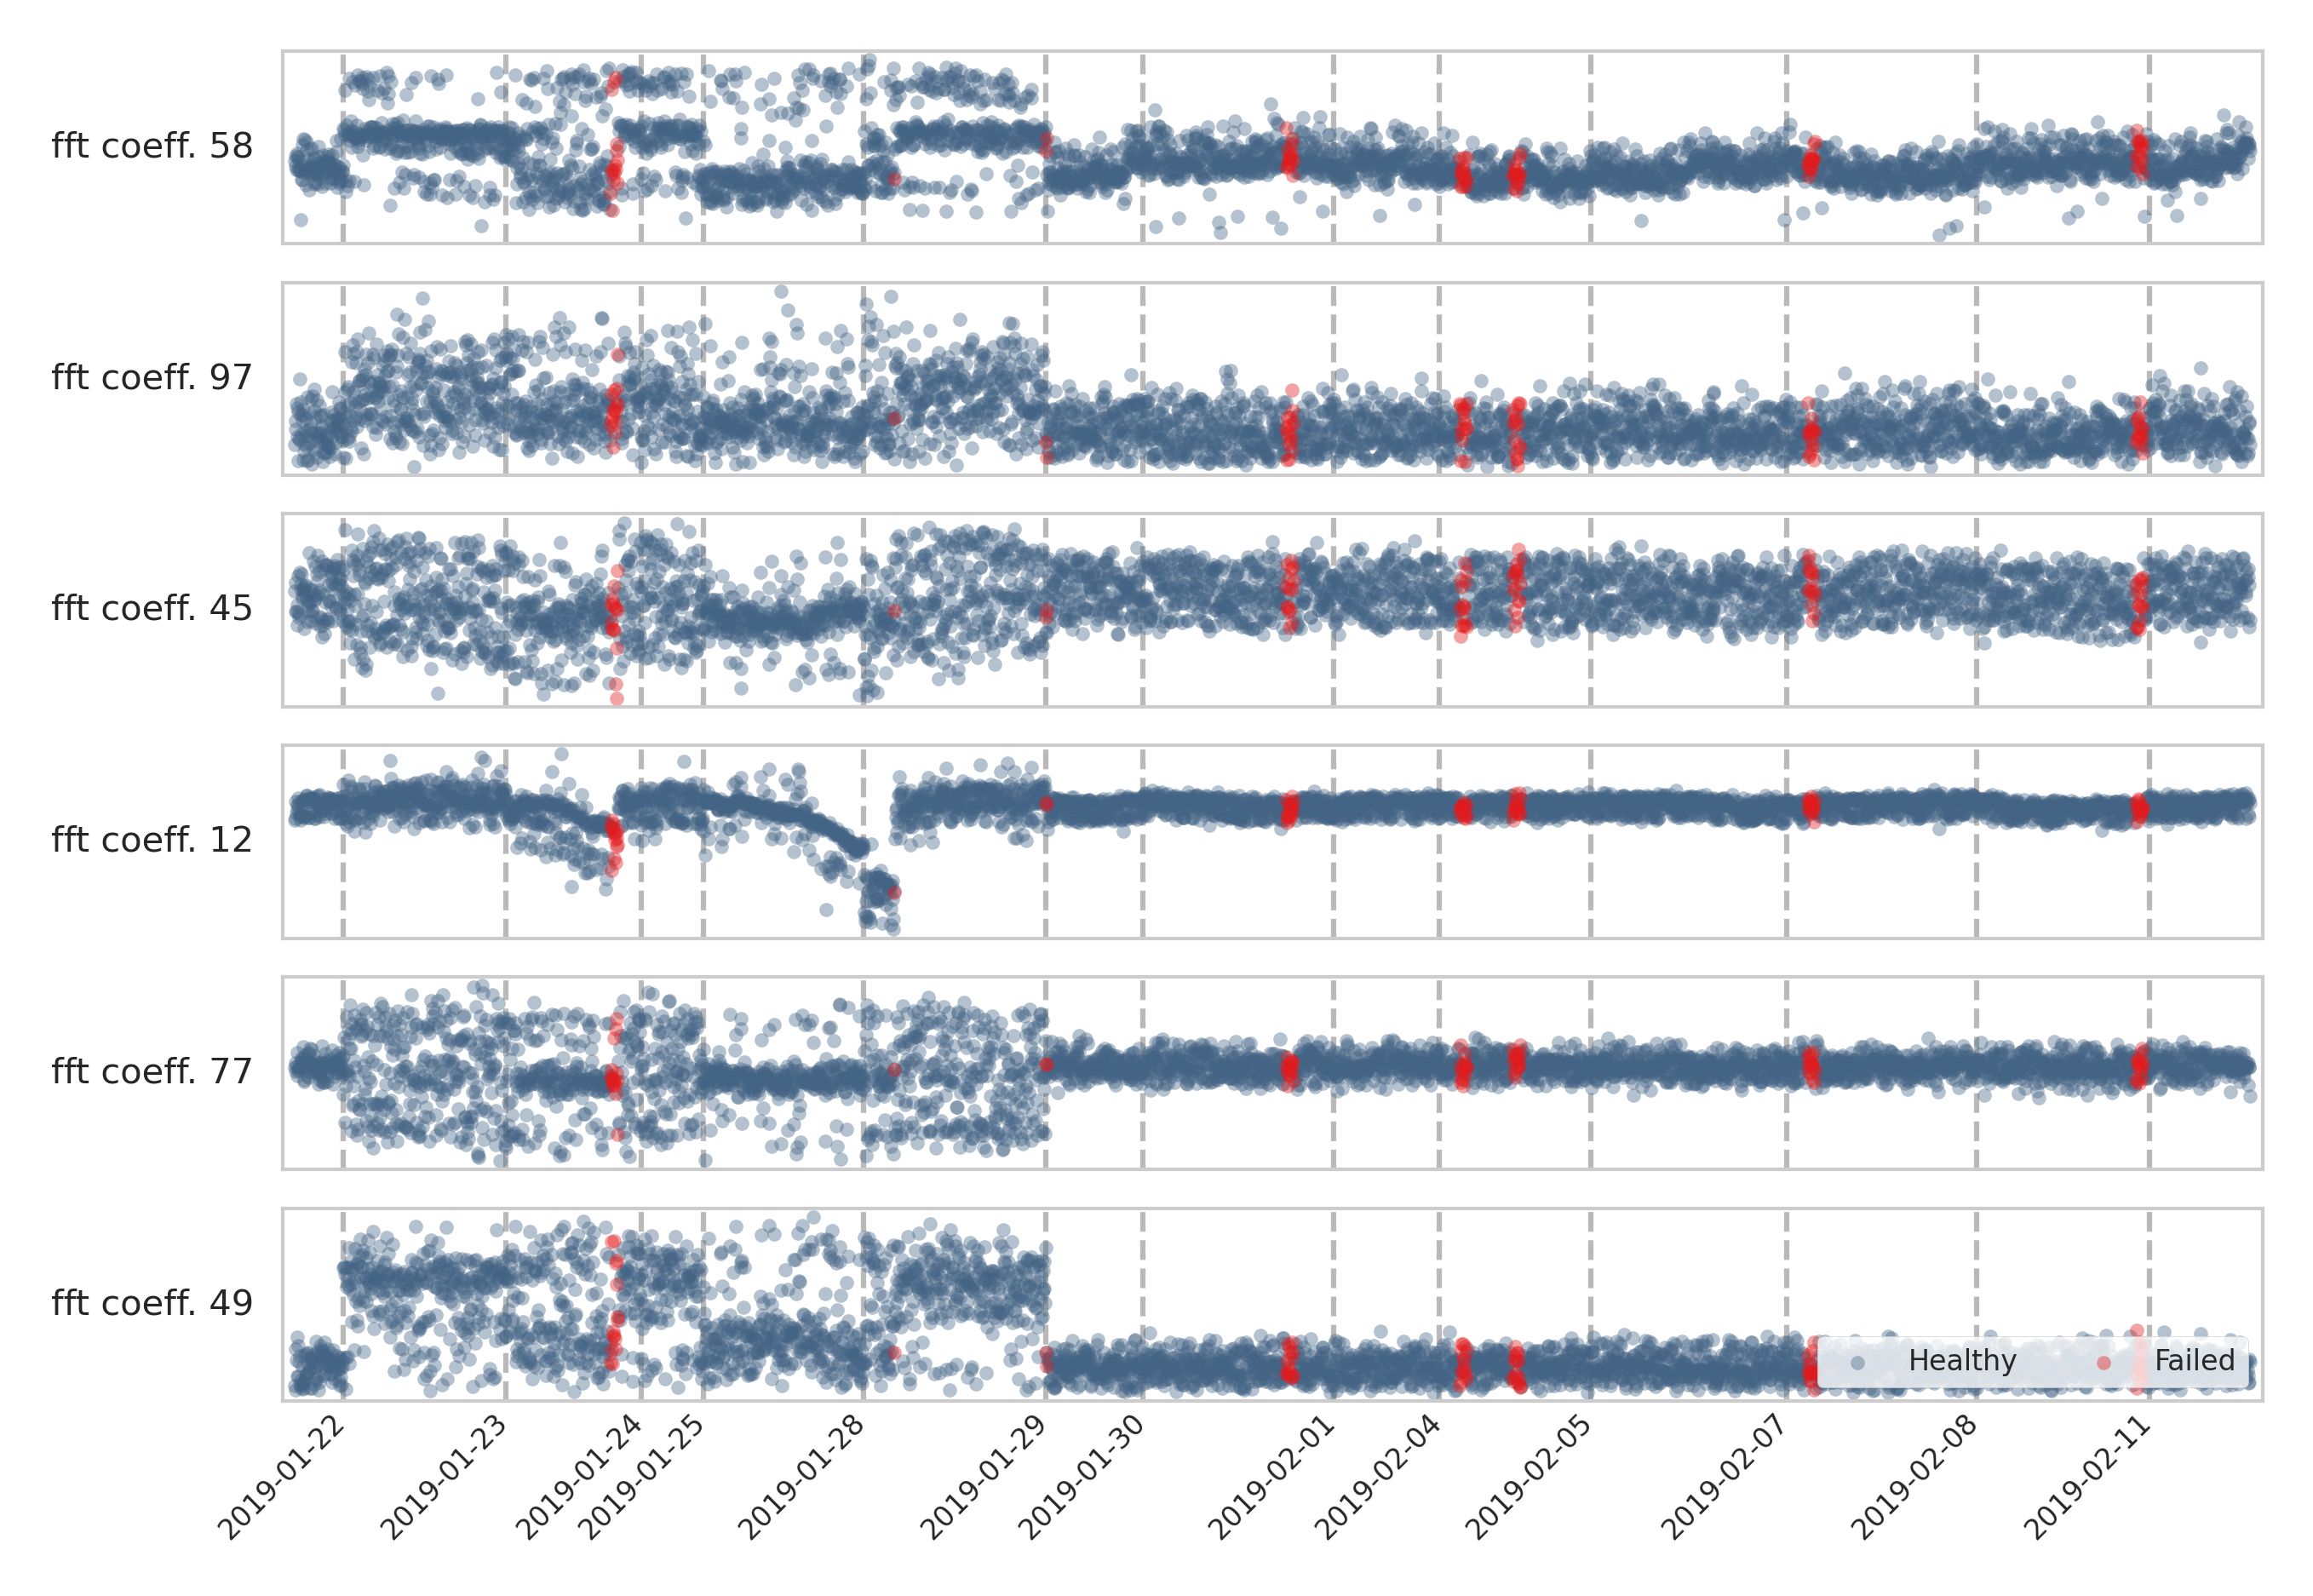

In [34]:
feat_to_trend = {
    'current__matrix_profile__feature_"mean"__threshold_0.98': "Max\nValue",
    'current__ratio_beyond_r_sigma__r_3':"RMS",
    'current__fft_coefficient__attr_"abs"__coeff_58':"Standard\nDeviation",
    'current__fft_coefficient__attr_"imag"__coeff_45': "Crest\nFactor",
    'current__linear_trend__attr_"slope"': "Est.\nTHD",
    'current__fft_aggregated__aggtype_"kurtosis"':"2nd\nSVD",
}

feat_to_trend= {
    'current__fft_coefficient__attr_"abs"__coeff_58' :"fft coeff. 58", 
    'current__fft_coefficient__attr_"abs"__coeff_97': "fft coeff. 97", 
    'current__fft_coefficient__attr_"imag"__coeff_45': "fft coeff. 45", 
    'current__fft_coefficient__attr_"real"__coeff_12': "fft coeff. 12", 
    'current__fft_coefficient__attr_"imag"__coeff_77': "fft coeff. 77",
    'current__fft_coefficient__attr_"abs"__coeff_49': "fft coeff. 49",
    }

plot_features_by_average_index_mpl(df, feat_to_trend=feat_to_trend, 
                                   tool_no=54, index_list=[2,3,4,5,6,7],
                                   chart_height=9000, start_index=1000, stop_index=4900)

### Get the Columns

In [13]:
# save df.columns to a separate csv file
col_list = df.columns.tolist()
col_list.remove("id")
col_list.remove("unix_date")
col_list.remove("tool_no")
col_list.remove("index_no")
col_list.remove("y")
col_list.remove("case_tool_54")

# save to csv
df_col_list = pd.DataFrame(col_list)
df_col_list.to_csv("cnc_features_54_custom_1_col_list.csv", index=False)

In [10]:
['current__fft_coefficient__attr_"abs"__coeff_58', 
'current__fft_coefficient__attr_"abs"__coeff_97', 
'current__fft_coefficient__attr_"imag"__coeff_45', 
'current__fft_coefficient__attr_"real"__coeff_12', 
'current__fft_coefficient__attr_"imag"__coeff_77', 
'current__fft_coefficient__attr_"abs"__coeff_49', 
'current__fft_coefficient__attr_"real"__coeff_51', 
'current__fft_coefficient__attr_"imag"__coeff_28', 
'current__fft_coefficient__attr_"real"__coeff_28', 
'current__fft_coefficient__attr_"angle"__coeff_77']

['current__fft_coefficient__attr_"abs"__coeff_58',
 'current__fft_coefficient__attr_"abs"__coeff_97',
 'current__fft_coefficient__attr_"imag"__coeff_45',
 'current__fft_coefficient__attr_"real"__coeff_12',
 'current__fft_coefficient__attr_"imag"__coeff_77',
 'current__fft_coefficient__attr_"abs"__coeff_49',
 'current__fft_coefficient__attr_"real"__coeff_51',
 'current__fft_coefficient__attr_"imag"__coeff_28',
 'current__fft_coefficient__attr_"real"__coeff_28',
 'current__fft_coefficient__attr_"angle"__coeff_77']